In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import jax.random as random
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import itertools

In [3]:
key = random.key(69)
key, key1, key2, key3 = random.split(key, 4)

In [4]:
N = 100
p = 6

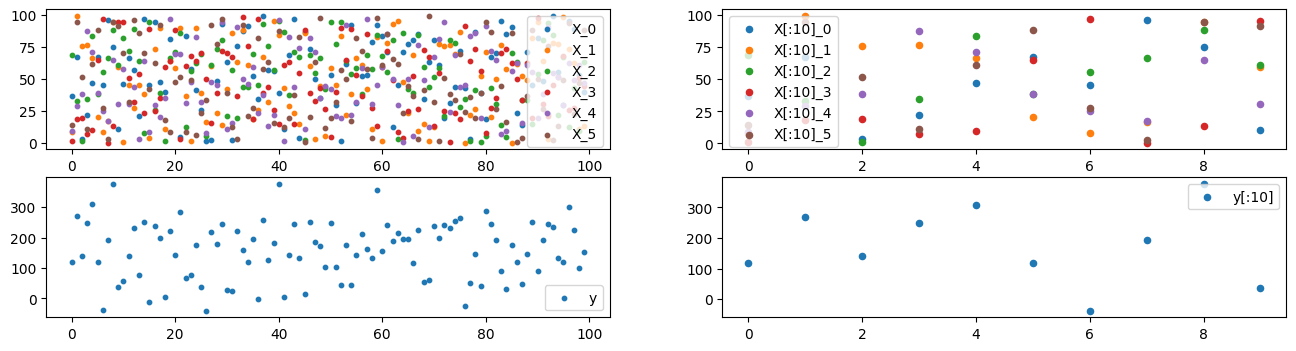

In [5]:
arange = jnp.arange(0, N)
B_real = random.normal(key1, p)
X = random.uniform(key2, (N, p), minval=0, maxval=100)
y_ideal = jnp.inner(X, B_real)
# y real
y = y_ideal + 2*random.normal(key3, N)
fig,ax = plt.subplots(2, 2, figsize=(16,4))
for k in range(p):
    ax[0, 0].scatter(jnp.arange(N), X[:, k], s=10, label=f'X_{k}')
    ax[0, 1].scatter(jnp.arange(10), X[:10, k], s=20, label=f'X[:10]_{k}')
ax[1, 0].scatter(jnp.arange(N), y[:], s=10, label='y')
ax[1, 1].scatter(jnp.arange(10), y[:10], s=20, label='y[:10]')

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

fig.show()


# Basic methods
## Least Squares
### Just random function

In [6]:
key, key1 = random.split(key)
B0 = 0
B = random.normal(key1, p)

In [7]:
f = B0 + jnp.dot(X, B)

In [8]:
residue = (y - f)**2

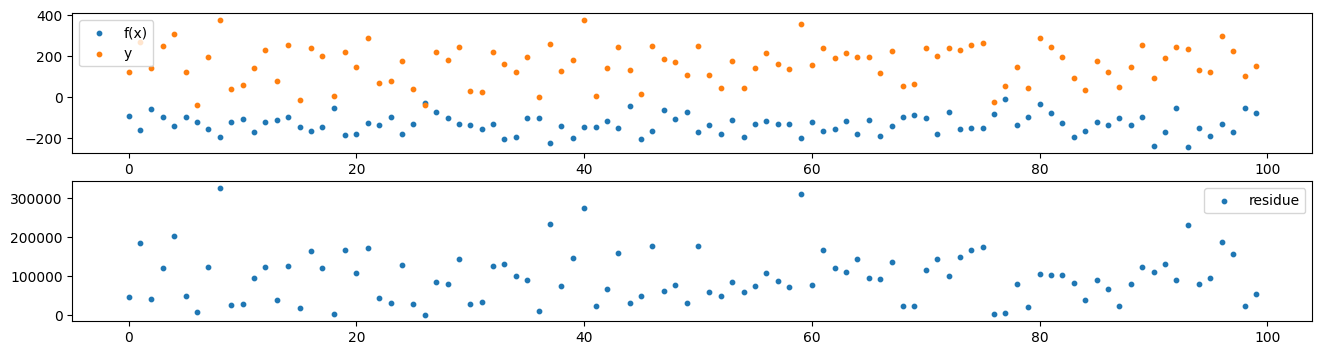

In [9]:
fig,ax = plt.subplots(2, 1, figsize=(16,4))
ax[0].scatter(jnp.arange(N), f[:], s=10, label='f(x)')
ax[0].scatter(jnp.arange(N), y[:], s=10, label='y')
ax[1].scatter(jnp.arange(N), residue[:], s=10, label='residue')
ax[0].legend()
ax[1].legend()

In [10]:
RSS = jnp.sum(residue)
RSS

Array(9724511., dtype=float32)

### Closed form solution

In [11]:
dRSS_dB = - 2*jnp.dot(X.T, y - f)
dRSS_dB

Array([-3479643.5, -3217766.5, -3287796.8, -2399177.2, -2983795.8,
       -2895854.8], dtype=float32)

We want to minimize $RSS$, which is defined as:

$$
RSS(\beta) = \sum_i^N{(y_i - x_i^T\beta)^2}
$$

We get:
$$
RSS(\beta) = (y - X\beta)^T(y - X\beta) =
$$
$$
= y^T y - y^T X\beta - \beta^T X^T y + \beta^T X^T X \beta =
$$
$$
= y^T y - 2 \beta^T X^T y + \beta^T X^T X \beta
$$

Then to get minimum, we want to calculate zero of derivative:

$$
\frac{\partial RSS}{\partial \beta} = -2X^Ty + 2X^TX\beta = -2X^T(y - X\beta)
$$

We're trying to solve for $\frac{\partial RSS}{\partial \beta} = 0$:
$$
0 = -2X^T(y - X\hat{\beta})
$$

$$
0 = X^Ty - X^TX\hat{\beta}
$$

$$
X^TX\hat{\beta} = X^Ty
$$

And we want to solve for $\hat{\beta}$.  
linalg.solve solves for $x$ in $Ax = b$:
```
x = jnp.linalg.solve(A, b)
```
In my case $A=X^TX$, $x=\hat{\beta}$ and $b=X^Ty$:
```
B_hat = jnp.linalg.solve(jnp.dot(X.T, X), jnp.dot(X.T, y))
```

The more straight-forward computation would be:
$$
\hat{\beta} = (X^TX)^{-1}X^Ty
$$
using:
```
B_hat = jnp.dot(jnp.linalg.inv(jnp.dot(X.T, X)), jnp.dot(X.T, y))
```
but python calculates that numerically, step by step which yields massive, massive floating-point errors.

In [12]:
B_hat = jnp.linalg.solve(jnp.dot(X.T, X), jnp.dot(X.T, y))
B_hat

Array([ 1.0924731 ,  0.9588226 ,  0.70255744, -2.0083447 ,  1.4975342 ,
        0.78273904], dtype=float32)

In [13]:
def f_hat(X):
    return B0 + jnp.dot(X, B_hat)

In [14]:
y_hat = f_hat(X)

In [15]:
residue_hat = (y - y_hat)**2

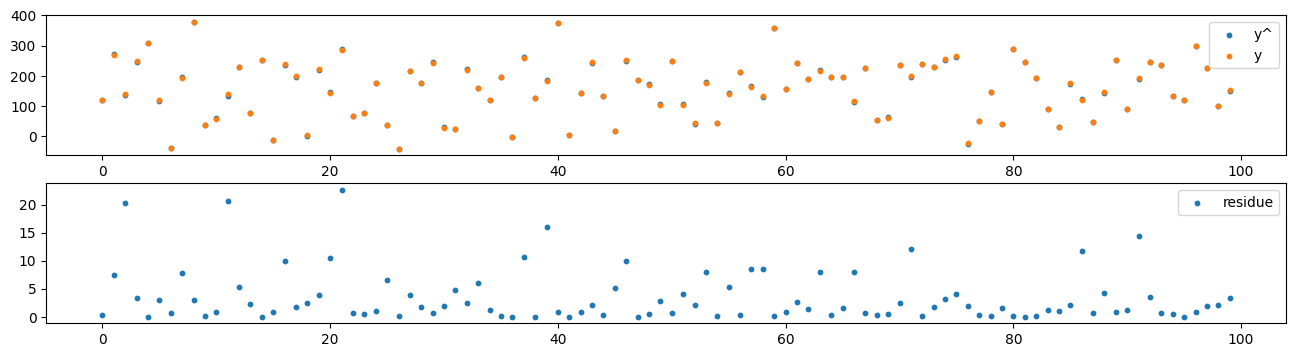

In [16]:
fig,ax = plt.subplots(2, 1, figsize=(16,4))
ax[0].scatter(jnp.arange(N), y_hat[:], s=10, label='y^')
ax[0].scatter(jnp.arange(N), y[:], s=10, label='y')
ax[1].scatter(jnp.arange(N), residue_hat[:], s=10, label='residue')
ax[0].legend()
ax[1].legend()

In [17]:
RSS_hat = jnp.sum(residue_hat)
RSS_hat

Array(349.45413, dtype=float32)

In [18]:
# dRSS/dB_hat
-2*jnp.dot(X.T, y - y_hat)

Array([ 0.07621002, -0.2001648 ,  0.02041626, -0.21895504,  0.35838127,
       -0.08480835], dtype=float32)

random sample

In [19]:
key, key1 = random.split(key)

In [20]:
random_x = random.uniform(key1, p, minval=0, maxval=100)
print(f"f_hat({random_x}) = {f_hat(random_x)}")

f_hat([30.03099  47.999657 97.483696 51.157917 32.589245 79.81143 ]) = 155.85140991210938


## K-NN

In [21]:
def euclidean_distance(A, B):
    return jnp.sqrt(jnp.sum((A - B)**2))

In [22]:
def nearest_neighbour(a):
    euclidean_dist = jax.vmap(euclidean_distance,(0, None))(X, a)
    return X[jnp.argmin(euclidean_dist)]

In [23]:
key, key1, key2 = random.split(key, 3)

In [24]:
a = random.normal(key1, p)
b = random.normal(key2, p)
euclidean_distance(a, b)

Array(3.5825198, dtype=float32)

In [25]:
print(f"searching nearest neighbour for:\n{b}:\n{nearest_neighbour(b)}")
print(f"\nsearching nearest neighbour for:\n{X[10]}:\n{nearest_neighbour(X[10])}")

searching nearest neighbour for:
[ 0.46837595 -2.199679   -0.5810247   1.5217786   1.0996879  -1.045044  ]:
[ 1.5871882 16.39378    5.757463  50.346565   7.869494  33.739708 ]

searching nearest neighbour for:
[46.444607   0.5445719 81.89818   94.80862   57.649242  70.51875  ]:
[46.444607   0.5445719 81.89818   94.80862   57.649242  70.51875  ]


In [26]:
key, key1 = random.split(key)
M=4
c = random.uniform(key1, (M, p), minval=0, maxval=100)

In [27]:
def k_nn(a, k):
    """
    a (M,p): M samples of p-dimensional test samples
    k: number of nearest neighbours

    The function is using X and y from training DS to decide output based on proximity
    """

    x_abs_sq = jnp.sum(X**2, axis=1, keepdims=True)
    a_abs_sq = jnp.sum(a**2, axis=1, keepdims=True).T
    # law of cosines
    distances = x_abs_sq + a_abs_sq -2*jnp.dot(X, a.T)

    ids = jnp.argsort(distances, axis=0)[:k].T

    # results from training ds for closest-k
    return y[ids]

In [28]:
k_nn(c, 5)

Array([[ 51.842186,  53.61382 , 121.09805 ,  36.45034 , 162.62346 ],
       [133.238   , 177.93724 , 245.08694 , 152.5616  , 186.33275 ],
       [121.09805 , 198.88675 , 221.33241 , 143.16316 , 177.2353  ],
       [245.08694 , 195.67712 , 254.66422 , 186.33275 , 309.0511  ]],      dtype=float32)

# Complexity reduction methods

Just picked up few.

## Subset selection

This methods aims to find such combination of features that retains/improves generalization, while reducing number of features from the original function.  
It is done by solving RSS for different combinations of $B$ parameters and comparing them against the fully parametrized set.  
This below - known as **best-subset selection** - is just the most basic methods that simply calculates ALL possible combinations and picks the one with lowest RSS.  

In [29]:
combs = []
for i in range(1, p+1):
    combs.extend(itertools.combinations(range(p), i))
combinations = [i for i in combs]
len(combinations)

63

In [30]:
results = []

for comb in combinations:
    X_temp = X[:, comb]
    B_hat_temp = jnp.linalg.solve(jnp.dot(X_temp.T, X_temp), jnp.dot(X_temp.T, y))
    y_hat_temp = jnp.dot(B_hat_temp, X_temp.T)
    RSS = jnp.sum((y - y_hat_temp)**2)
    results.append((comb, RSS))

In [31]:
print(results)

[((0,), Array(1034351.6, dtype=float32)), ((1,), Array(1032876.44, dtype=float32)), ((2,), Array(1077449.1, dtype=float32)), ((3,), Array(2305837.8, dtype=float32)), ((4,), Array(707691.56, dtype=float32)), ((5,), Array(1151522.2, dtype=float32)), ((0, 1), Array(691359.2, dtype=float32)), ((0, 2), Array(768366.6, dtype=float32)), ((0, 3), Array(975684.4, dtype=float32)), ((0, 4), Array(551689.4, dtype=float32)), ((0, 5), Array(726462.6, dtype=float32)), ((1, 2), Array(704124.25, dtype=float32)), ((1, 3), Array(1032047.5, dtype=float32)), ((1, 4), Array(467623.38, dtype=float32)), ((1, 5), Array(725871.25, dtype=float32)), ((2, 3), Array(1050904.1, dtype=float32)), ((2, 4), Array(573116.7, dtype=float32)), ((2, 5), Array(817603.3, dtype=float32)), ((3, 4), Array(666654.7, dtype=float32)), ((3, 5), Array(1149337.8, dtype=float32)), ((4, 5), Array(554240.1, dtype=float32)), ((0, 1, 2), Array(589258.56, dtype=float32)), ((0, 1, 3), Array(521726.75, dtype=float32)), ((0, 1, 4), Array(420439

In [32]:
best_of_k = [min([res for res in results if len(res[0]) == k], key=lambda x: x[1]) for k in range(1, p+1)]
best_comb = min(results, key=lambda x: x[1])

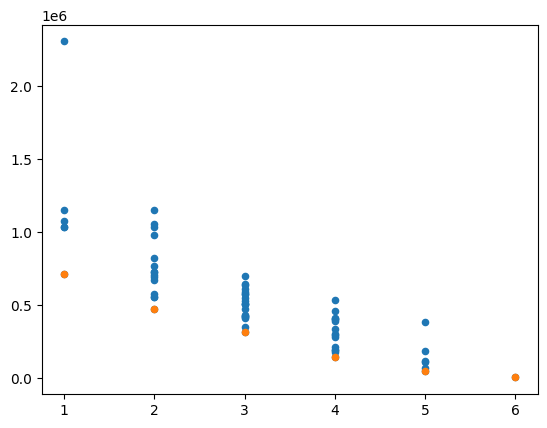

In [33]:
# make this plt exponential y axis
plt.scatter([len(i[0]) for i in results], [i[1] for i in results], s=20)
plt.scatter([len(i[0]) for i in best_of_k], [i[1] for i in best_of_k], s=20)
plt.show()

In [34]:
print(f"best combination: {best_comb}")

best combination: ((0, 1, 2, 3, 4, 5), Array(349.45413, dtype=float32))


## Ridge Regularization

Ridge regression is adding penalty component $\lambda$ to linear regression:

$$
\hat{\beta}^{ridge} = argmin(\beta)\left\{\sum_{i=1}^N(y_i-\beta_0-\sum_{j=1}^px_{ij}\beta_j)^2 + \lambda \sum_{j=1}^p\beta_j^2\right\}
$$

the criterion would be then:

$$
RSS(\lambda) = (y-X\beta)^T(y-X\beta) + \lambda \beta^T\beta
$$

and then:

$$
\frac{\partial RSS(\lambda)}{\partial \beta} = -X^Ty + X^TX\beta + \lambda \beta = 0
$$

gives solution:

$$
\hat{\beta}^{ridge} = (X^TX + \lambda I)^{-1}X^Ty
$$

In [70]:
def solve_ridge(lambda_):
    #lambda_ = 10.9
    B_ridge = jnp.linalg.solve(jnp.dot(X.T, X) + lambda_ * jnp.eye(X.shape[1]), jnp.dot(X.T, y))
    y_hat_ridge = jnp.dot(B_ridge, X.T)
    return B_ridge, y_hat_ridge
B_ridge, y_hat_ridge = solve_ridge(0.9)
RSS_ridge = jnp.sum((y - y_hat_ridge)**2)
print(RSS_ridge)

349.45435


In [71]:
lambdas = jnp.linspace(0, 1000)
B_ridges, y_hats = jax.vmap(solve_ridge)(lambdas)
RSS_s = jax.vmap(lambda y_hat_ridge: jnp.sum((y - y_hat_ridge)**2))(y_hats)

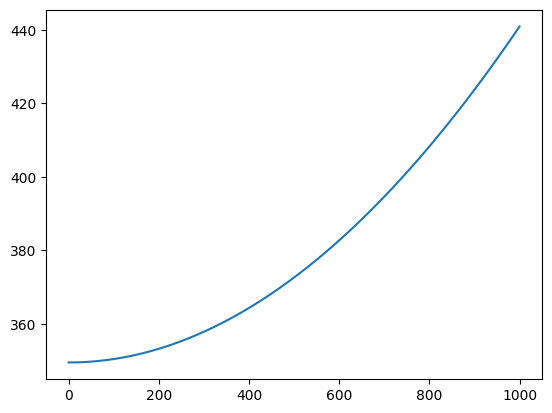

In [72]:
plt.plot(lambdas, RSS_s)